# Classifieur Adaboost
AdaBoost est un modèle d'ensemble qui améliore la performance en séquence en accordant plus de poids aux exemples mal classés. Il combine des classificateurs faibles, comme des arbres de décision peu profonds, pour former un modèle global robuste adapté à la classification.

In [21]:
import DataManagement as DM
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier,ExtraTreesClassifier,BaggingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

dataset = DM.Dataset('data/train.csv')
dataset.split_data(test_size=0.3, seed=0, stratified=True)
dataset.info()


(693, 192) (297, 192)
##### Informations #####
  - Nb classes   : 99 ( Dim : 192 )
  - Nb samples   : 990
     - Training  : 693 ( 70.0 % )
     - Test      : 297 ( 30.0 % )
########################


Puisque qu'on a beaucoup de classe et très peu de données par classe, on a séparé notre ensemble de données de façon à avoir autant de données dans chaque classe.

## Entrainement

Pour notre classifieur Adaboost, nous utilisons deux hyperparamètres clés :

- base_estimator: c'est le faible 'learner' utilisé pour entrainer le réseau. le DecisionTreeClassifier est utilisé en tant que faible learner par défaut.
- Le nombre d'estimateurs : qui indique le nombre de faible 'learners' à entrainer.
- Le learning rate : qui contribue au poids des faibles 'learners'. la valeur par défaut utilisée est 1.

Bien que le nombre d'estimateur soit souvent l'hyperparamètre le plus crucial, l'impact des autres hyperparamètres sur les performances du modèle sera étudié.

### Recherche des hyperparamètres

On utilise une validation croisée à 5 plis. On utilise un nombre de plis assez petit parce qu'on a très peu de données par classe (seulement 7) et on veut éviter d'avoir des plis qui n'ont pas de données pour certaines classes.

In [26]:

hyperparameters_dt = {
        # Hyperparamètres AdaBoostClassifier
        'n_estimators': range(60, 101, 10),
        'learning_rate': [0.01, 0.1, 1.0],
        'base_estimator': [RandomForestClassifier(), ExtraTreesClassifier(),SVC(probability=True, kernel='linear')],
    }

grid, results = DM.train_model(AdaBoostClassifier(), hyperparameters_dt, dataset)
print('Best:', grid.best_params_, 'with score {:.3}'.format(grid.best_score_))


Fitting 5 folds for each of 45 candidates, totalling 225 fits


Best: {'base_estimator': ExtraTreesClassifier(), 'learning_rate': 0.1, 'n_estimators': 100} with score 0.973


### Analyse de l'entrainement

Le nombre optimal d'estimateurs (n_estimators) est de 100, ce qui suggère que le modèle Adaboost utilise un ensemble significatif d'estimateurs pour réaliser des prédictions précises sur les espèces de feuilles. En analysant les performances du modèle à ce nombre spécifique d'estimateurs, nous pouvons évaluer l'impact des autres hyperparamètres sur ces résultats.

In [31]:
results[results.param_n_estimators == grid.best_params_['n_estimators']].sort_values(by='rank_test_score')

,param_n_estimators,param_learning_rate,param_base_estimator,mean_test_score,rank_test_score
24,100,0.1,ExtraTreesClassifier(),0.972610,1
14,100,1.0,RandomForestClassifier(),0.971160,5
19,100,0.01,ExtraTreesClassifier(),0.971160,5
29,100,1.0,ExtraTreesClassifier(),0.968251,18
9,100,0.1,RandomForestClassifier(),0.966854,19
4,100,0.01,RandomForestClassifier(),0.965384,25
39,100,0.1,"SVC(kernel='linear', probability=True)",0.512282,33
44,100,1.0,"SVC(kernel='linear', probability=True)",0.427098,36
34,100,0.01,"SVC(kernel='linear', probability=True)",0.150078,41


On remarque que le type de classifieur faible influence grandement la précision. En effet, les classifieurs ExtraTree ont de meilleures performance que le randomForest même si ces dernières reste performantes. Par contre le SVC a de loin les pires performances du lot.

Concernant le learning rate, ses valeurs optimales semble dépendre du type de classifieur faible qui préféreraient soit un plus petit soit un plus grand learning rate. 

In [73]:
print(results.query('param_learning_rate == 1.0 and param_base_estimator == "ExtraTreesClassifier()"'))

ValueError: "ExtraTreesClassifier" is not a supported function

On peut tracer un graphique du score en fonction des différentes valeurs d'hyperparamètres pour réellement voir l'impact de leur variation sur le score.

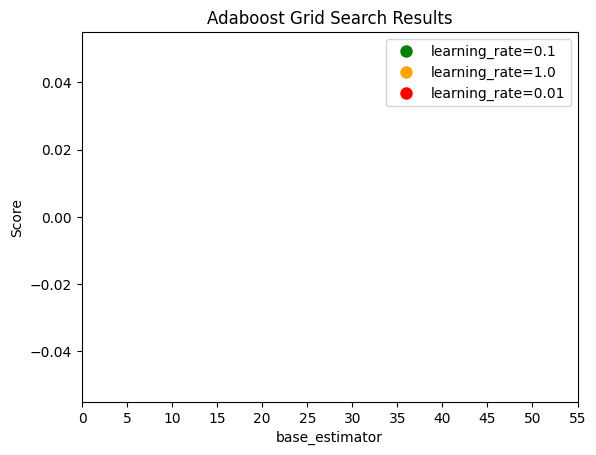

In [67]:
plt.scatter(results.query('param_learning_rate == 0.1 and param_base_estimator == "ExtraTreesClassifier"')['param_n_estimators'],
            results.query('param_learning_rate == 0.1 and param_base_estimator == "ExtraTreesClassifier"')['mean_test_score'],
            marker='o', color='green', label='learning_rate=0.1, base_estimator="ExtraTreesClassifier"')
plt.scatter(results.query('param_learning_rate == 1.0 and param_base_estimator == "ExtraTreesClassifier"')['param_n_estimators'],
            results.query('param_learning_rate == 1.0 and param_base_estimator == "ExtraTreesClassifier"')['mean_test_score'],
            marker='o', color='orange', label='learning_rate=1.0, base_estimator="ExtraTreesClassifier"')
plt.scatter(results.query('param_learning_rate == 0.01 and param_base_estimator == "ExtraTreesClassifier"')['param_n_estimators'],
            results.query('param_learning_rate == 0.01 and param_base_estimator == "ExtraTreesClassifier"')['mean_test_score'],
            marker='o', color='red', label='learning_rate=0.01, base_estimator="ExtraTreesClassifier"')

plt.xlabel("base_estimator")
plt.ylabel("Score")
plt.title("Adaboost Grid Search Results")
plt.xticks(np.arange(0, 60, 5))  # Graduations de 1 en 1 sur l'abscisse
legend = [
    plt.Line2D([0], [0], marker='o', color='white', markerfacecolor='green', markersize=10, label='learning_rate=0.1'),
    plt.Line2D([0], [0], marker='o', color='white', markerfacecolor='orange', markersize=10, label='learning_rate=1.0'),
    plt.Line2D([0], [0], marker='o', color='white', markerfacecolor='red', markersize=10, label='learning_rate=0.01')
    ]
plt.legend(handles=legend)

plt.show()



# plt.xlabel("base_estimator")
# plt.ylabel("Score")
# plt.title("Decision Tree Grid Search Results")
# plt.xticks(np.arange(0, 60, 5))  # Graduations de 1 en 1 sur l'abscisse
# legend = [
#     plt.Line2D([0], [0], marker='s', color='white', markerfacecolor='black', markersize=10, label='gini'), 
#     plt.Line2D([0], [0], marker='o', color='white', markerfacecolor='black', markersize=10, label='entropy'), 
#     plt.Line2D([0], [0], marker='^', color='white', markerfacecolor='black', markersize=10, label='log_loss'),
#     plt.Line2D([0], [0], color='blue', linewidth=5, label='random'),
#     plt.Line2D([0], [0], color='red', linewidth=5, label='best')
#     ]
# plt.legend(handles=legend, ncols=2)

# plt.show()
plt.show()


Nous observons que le choix du critère de séparation n'a pas un impact significatif sur les performances du modèle. En effet, les scores moyens obtenus pour les critères "gini", "entropy", et "log_loss" ne présentent pas de différences notables. Cependant, on observe que le critère "gini" tend à obtenir de légèrement meilleures performances en moyenne.

Par ailleurs, en ce qui concerne le choix du séparateur, il semble que le séparateur "best" soit en moyenne plus performant que le séparateur "random". Les résultats montrent que, quel que soit le critère utilisé, le splitter "best" obtient généralement des scores moyens supérieurs. Bien que la différence ne soit pas toujours très significative, cette tendance suggère que le processus de sélection "best" qui évalue toutes les divisions possibles conduit à de meilleures performances que le choix aléatoire de la division "random".

## Évaluation

On évalue le meilleur modèle entrainé à l'aide de notre ensemble de test. Pour l'évaluation, on regarde les métriques suivantes:
- La précision ("precision") : la proportion de données appartenant réellement à leur classe prédite
- Le rappel ("recall") : la proportion des données bien classées (la justesse des prédictions pour une classe)
- Le f1-score : la moyenne harmonique de la précision et du rappel

Comme nous sommes dans une situation de classification multi-classe, on calcule ces métriques individuellement pour chaque classe. On peut ensuite regarder la distribution des résultats pour évaluer notre modèle.

### Averages ###
   - precision : 71.215% ± 31.240%
   - recall    : 66.330% ± 29.545%
   - f1_score  : 66.365% ± 27.566%
################


C:\Users\Yanni\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


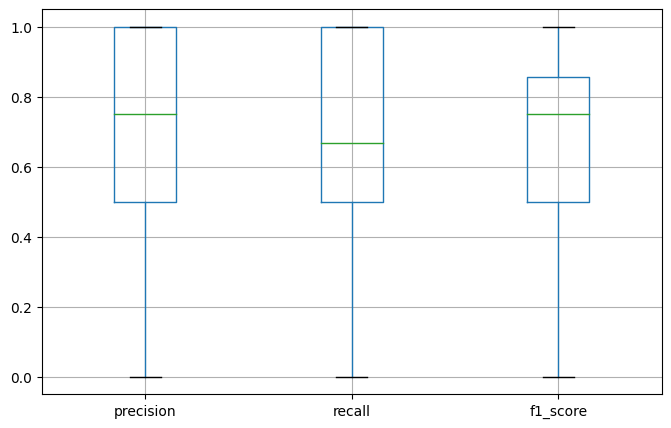

In [55]:
test_preds = grid.predict(dataset.x_test)
test_reports = DM.evaluate_predictions(dataset.t_test, test_preds, dataset.classes)

Comme nous avons 99 classes, il n'est pas pratique de regarder les résultats pour chacune d'entre elles. On regarde plutôt la moyenne de chaque métrique sur l'ensemble des classes. On peut alors voir que notre modèle fonctionne très bien. Il est à la fois précis et juste.

Comme on peut le voir dans les boxplots, les prédictions sont loins parfaites pour la grande majorité des classes. En effet, nous avons des boxplots très étendus, avec des médianes ne dépassant pas 0.7,et des quartiles et extrémités de moustaches faibles. 

Nous pouvons ensuite afficher les classes où le modèles a moins bien performé, qui sont au nombre de 85 sur les 99 existantes, témoignant d'un modèle peu performant :

In [78]:
bad_classes = test_reports.query('precision < 1.0 or recall < 1.0')
print(bad_classes)
print('Sum:', len(bad_classes))

                              precision    recall  f1_score
Acer_Capillipes                0.750000  1.000000  0.857143
Acer_Circinatum                0.333333  0.333333  0.333333
Acer_Opalus                    0.000000  0.000000  0.000000
Acer_Palmatum                  1.000000  0.666667  0.800000
Acer_Pictum                    1.000000  0.666667  0.800000
...                                 ...       ...       ...
Tilia_Tomentosa                0.666667  0.666667  0.666667
Ulmus_Bergmanniana             1.000000  0.666667  0.800000
Viburnum_Tinus                 1.000000  0.666667  0.800000
Viburnum_x_Rhytidophylloides   0.333333  0.333333  0.333333
Zelkova_Serrata                0.000000  0.000000  0.000000

[83 rows x 3 columns]
Sum: 83


Pour évaluer les performances de notre modèle de Decision Tree, nous pouvons également utiliser une matrice de confusion pour visualiser les prédictions incorrectes sur l'ensemble de test. La matrice de confusion affiche les classifications réelles par rapport aux classifications prédites, permettant ainsi d'identifier les erreurs et les tendances de notre modèle.

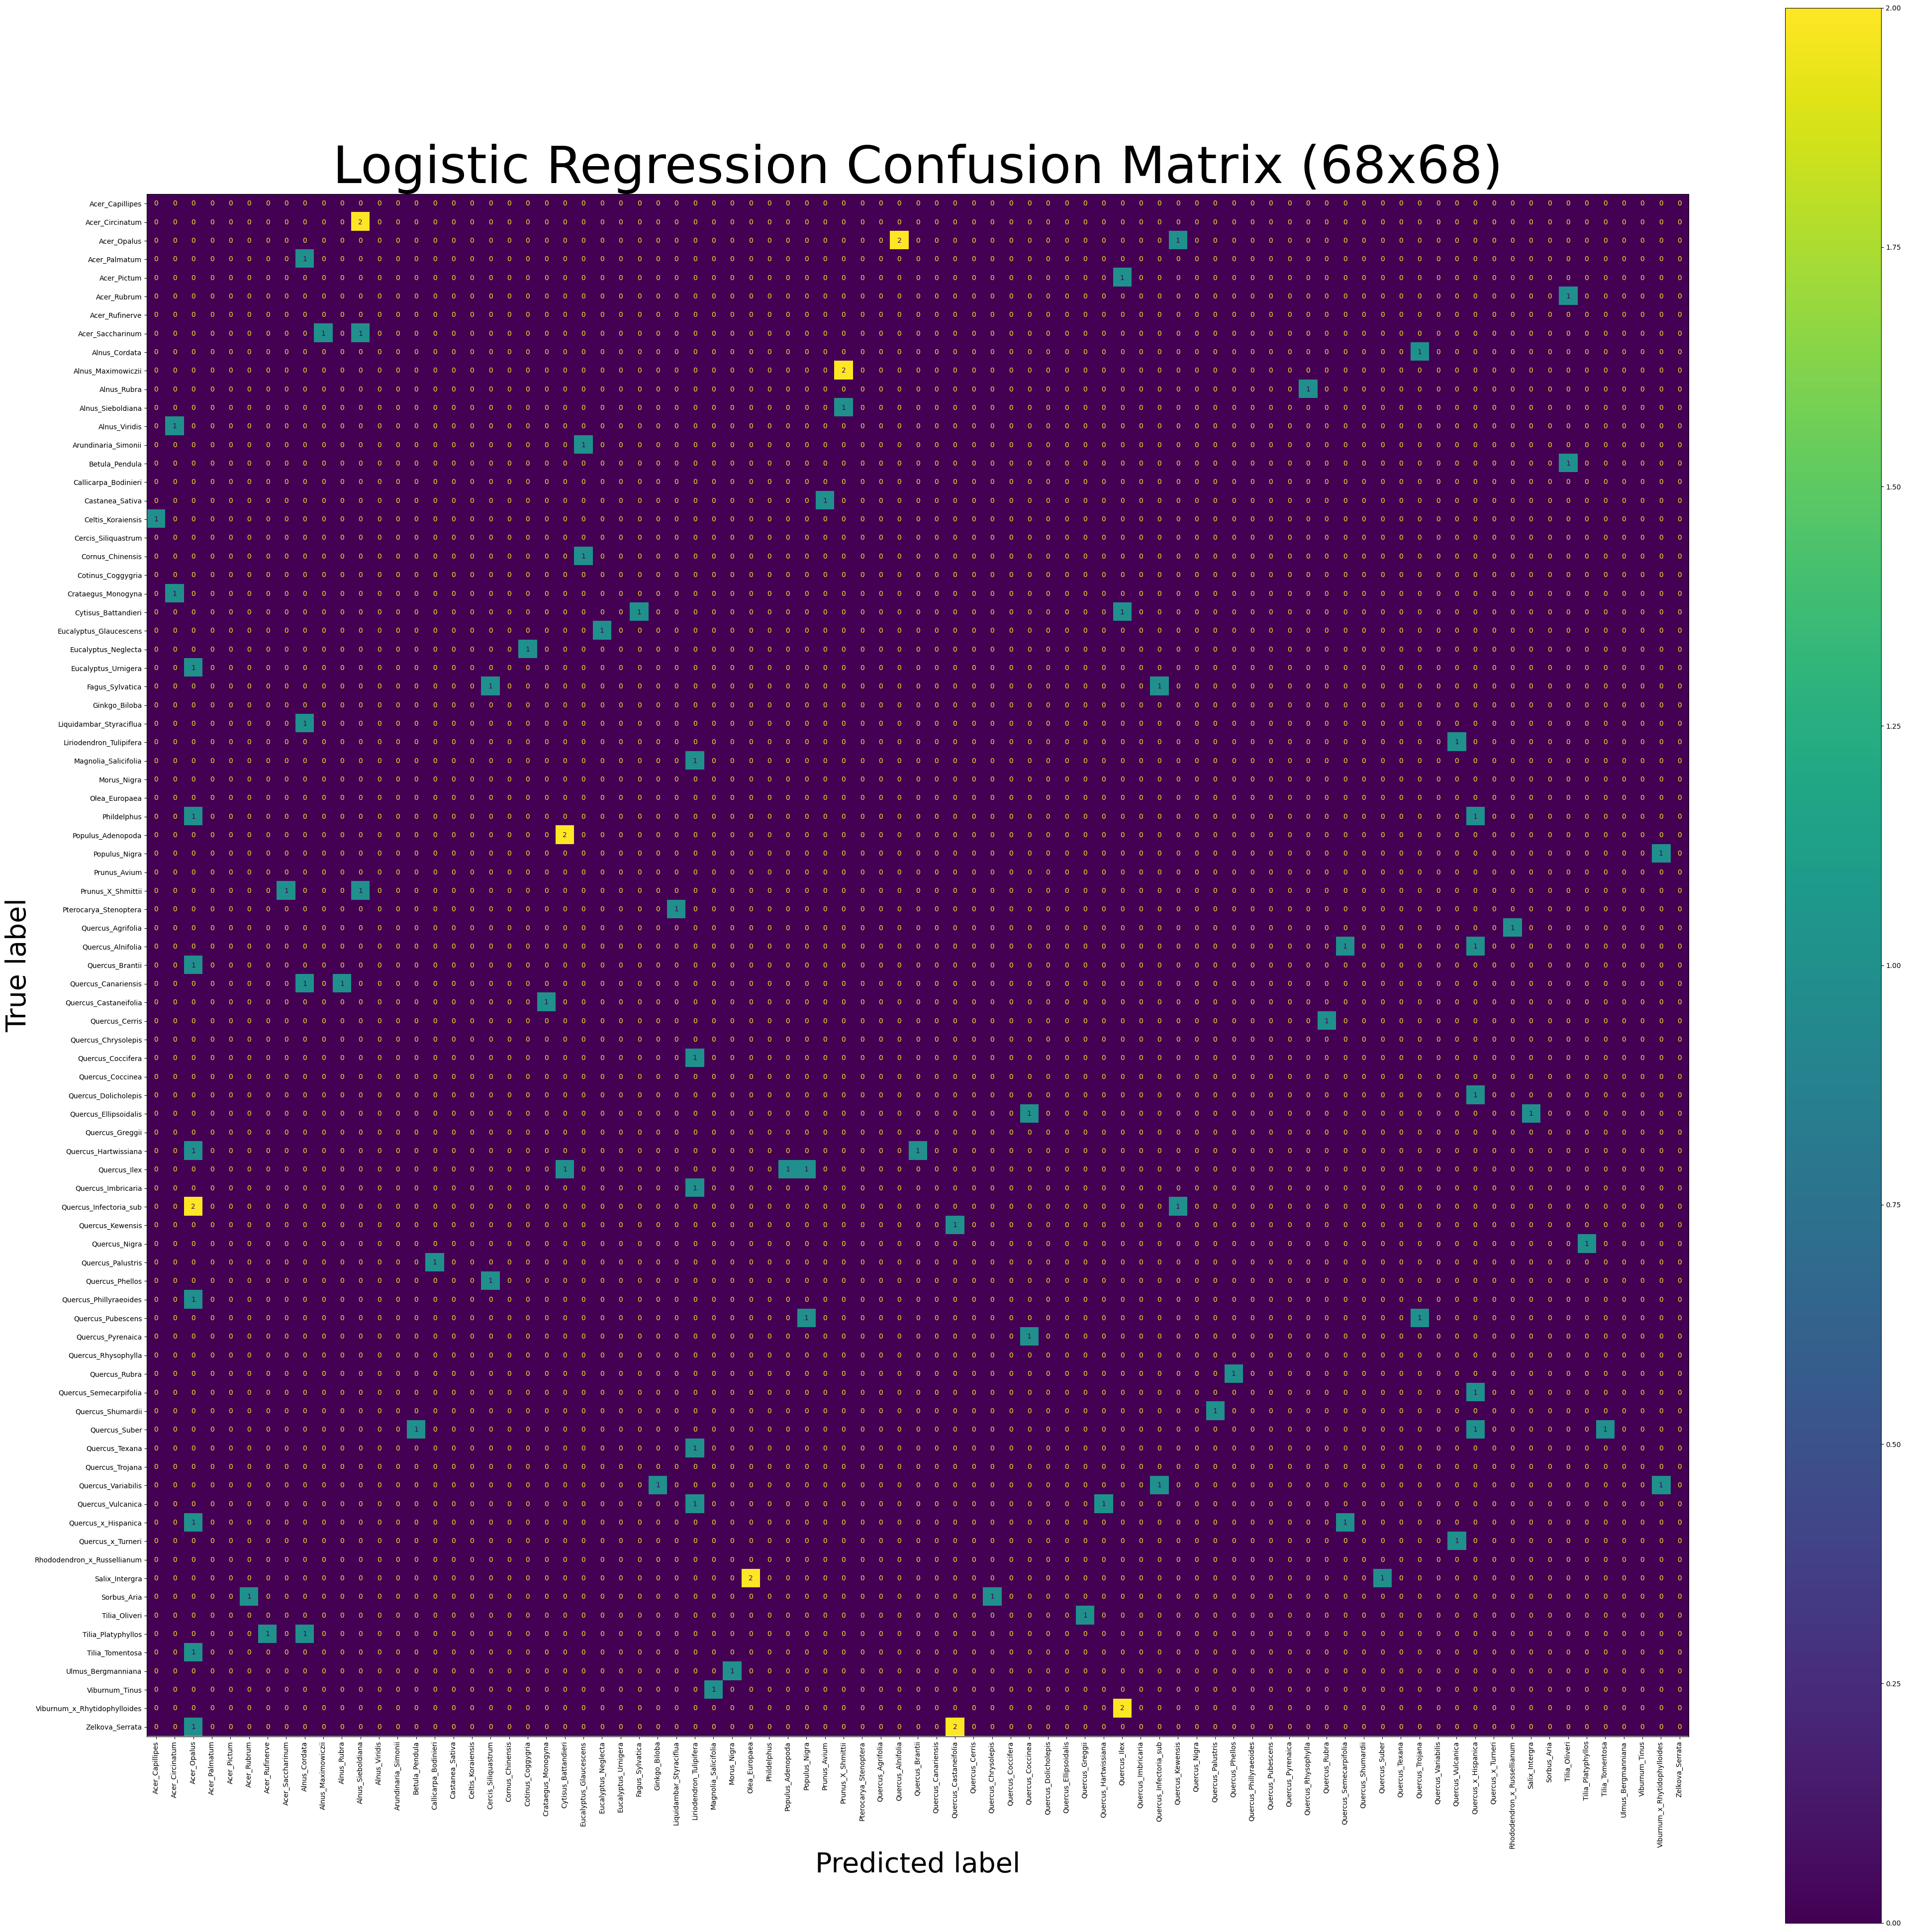

In [82]:
from sklearn.metrics import ConfusionMatrixDisplay

# Get all the wrong predictions
bad_preds = DM.extract_bad_predictions(dataset.t_test, test_preds, labels=dataset.classes, ids=dataset.id_test)
matrix_size = len(bad_preds['True Class'].unique())

# Display them as a confusion matrix
display = ConfusionMatrixDisplay.from_predictions(bad_preds['True Class'], bad_preds['Predicted Class'], 
                                                  labels=bad_classes.index, xticks_rotation='vertical')
display.figure_.set_figwidth(50)
display.figure_.set_figheight(50)

# Ajustez la taille de la police des titres des axes
display.ax_.set_title(f'Logistic Regression Confusion Matrix ({matrix_size}x{matrix_size})', fontsize=75)
display.ax_.xaxis.label.set_size(40)  # Ajustez la taille de la police pour l'axe des x
display.ax_.yaxis.label.set_size(40)  # Ajustez la taille de la police pour l'axe des y

plt.show()


Nous observons donc une grande quantité d'erreur pour un grand nombre de classe ayant été prédite à un moment ou à un autre incorrectement. Les grandes dimensions de cette matrice témoigne de ces nombreuses erreurs ayant été commises. 

### Conclusion

Les paramètres optimaux pour notre modèle de Random Forest sont une profondeur maximale illimitée, un nombre minimal d'échantillons pour la division fixé à 5, le critère de séparation "gini", et un séparateur aléatoire. Cependant, malgré ces paramètres ajustés, les performances du modèle restent relativement modestes, les indicateurs de performances ne dépassant pas les 65%.

En effet, les métriques de performance, oscillant entre 58% et 64%, indiquent une capacité de prédiction relativement faible. La nature complexe de notre problème de classification semble dépasser les capacités du classifieur Decision Tree, qui a du mal à saisir les relations subtiles entre les caractéristiques pour discriminer avec précision entre les nombreuses classes.

Il est important de noter que les résultats obtenus ne remettent pas en question l'utilité des arbres de décision dans d'autres contextes, mais plutôt soulignent la nécessité de choisir des modèles adaptés à la complexité de notre ensemble de données spécifique. En conséquence, ces résultats renforcent la pertinence de l'exploration de modèles plus sophistiqués, tels que le classifieur Random Forest, pour traiter efficacement notre problème de classification des espèces de feuilles.
